# Figure 3
This figure compares the DAS sensitivity in a narrow band to the seismometer sensitivity for an earthquake record. The seismometer used is a colocated Trillium 3-axis Posthole Compact 120s sensor. The example is from the Fairbanks Array, where the seismometer is located at the intersection of two orthogonal DAS trenched cables. The earthquake path is aligned with one of the DAS trenches, meaning the horizontal components of the DAS array decompose into the transverse and radial components of ground motion, in theory. Mathematical rotation of the seismometer into this orientation (backazimuth=200 degrees) yields aligned sensor components. There is no vertical DAS component. 

DAS data must be scaled by the instrument manufacturing values used in the module "scaleData" below. This yields data in nm/seconds, to which we apply a time-derivative to compare data in units of acceleration.

Nate Lindsey 2017

In [1]:
%matplotlib notebook
import numpy as np
from pylab import figure, cm
from matplotlib.colors import LogNorm
import obspy as obs
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy

### Some useful modules to process DAS and inertial seismometer data

In [ ]:
def mat2st(mat):
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import h5py 
    import obspy as obs
    from obspy.signal.filter import lowpass, bandpass
    import scipy.integrate
    
    def streamInit():
        st = obs.read()
        tr = obs.Trace()
        st.clear()
        return st,tr

    st,tr=streamInit()

    with h5py.File(mat) as f:
        try:
            fh = [f[element[0]][:] for element in f['dsi_downsampled/fh']]
            data = [f[element[0]][:] for element in f['dsi_downsampled/dat']]
        except KeyError:
            try:
                fh = [f[element[0]][:] for element in f['dsi/fh']]
                data = [f[element[0]][:] for element in f['dsi/dat']]
            except KeyError:
                try:
                    fh = [f[element[0]][:] for element in f['DSI/fh']]
                    data = [f[element[0]][:] for element in f['DSI/dat']]
                except KeyError:
                    fh = [f[element[0]][:] for element in f['dsi2/fh']]
                    data = [f[element[0]][:] for element in f['dsi2/dat']]
        delta=fh[7]
        nChan = np.shape(data)[1]
        nSamp = np.shape(data)[2]
        for chan in np.arange(1,nChan,1):
            tr = obs.Trace()
            tr.stats.npts=nSamp
            tr.stats.delta=delta
            tr.stats.network='LBNL'
            tr.stats.station=chan
            tr.stats.location=''
            tr.stats.channel=''
            tr.stats.distance=chan
            tr.data = data[0][chan][:]
            st.append(tr)
        return st
    
def scaleData(streamin):
    a=1;
    b=2048;
    scale=a/b
    gain = 116 # nm / radian
    timefac=0.001; #seconds/timesample
    streamout=streamin.copy()
    for tr in streamout:
        tr.data = tr.data*scale*gain/timefac
    return streamout

def bpStream(s,nc,lowcut,highcut):
    from obspy.signal.filter import bandpass
    import copy
    import obspy
    stream_bp = s.copy()
    try:
        for a in range(len(stream_bp)):
            dt = stream_bp[a].stats.delta
            stream_bp[a].data =  bandpass(stream_bp[a].data, lowcut, highcut, df=1/stream_bp[a].stats.delta, corners=nc, zerophase=False);
    except:
        dt = stream_bp.stats.delta
        stream_bp.data =  bandpass(stream_bp.data, lowcut, highcut, df=1/stream_bp.stats.delta, corners=nc, zerophase=False);
   
    return stream_bp

def stack_stream_specific(stream,startchannel,nchannels):
    import copy
    tracestack=stream[0].copy()
    A=[a.data for a in stream[startchannel:startchannel+nchannels]]
    tracestack.data = np.mean(np.array(A),0)
    return tracestack
def stack_stream_specific_median(stream,startchannel,nchannels):
    import copy
    tracestack=stream[0].copy()
    A=[a.data for a in stream[startchannel:startchannel+nchannels]]
    tracestack.data = np.median(np.array(A),0)
    return tracestack

def v2a(tr):
    try:
        tr2 = tr.copy()
        tr2.data = np.gradient(tr2.data, tr2.stats.delta)
        return tr2
    except:
        st2 = tr.copy()
        D = [np.gradient(t.data, t.stats.delta) for t in st2]
        st2.data = np.array(D)
        return st2

# load seismometer data

In [ ]:
evt='Alaska Range'
eq='160826'
# bpath="/Users/njlindsey/Workspace/projectsBerkeley/DASeq/wd/FBX2016/DAS/160826/bb_sac_postIRR"
# path1='/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig1_fbx_road_gather/dsi_160826_12_24_Line1_20_30.mat'
path1='/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig3_particle_velocity_comparison/data/das/160826_M38/Line1_channels_1_51.mat' 
# pathC='/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig1_fbx_road_gather/dsi_160826_12_24_LineC_100_110.mat'
pathC='/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig3_particle_velocity_comparison/data/das/160826_M38/LineC_channels_1_180.mat'
# pathR='/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig1_fbx_road_gather/dsi_160826_12_24_LineR_390_420.mat'
st = UTCDateTime("2016-08-26T23:17:42.000000Z")
file_prefix='2016.239.23' ##Broadband

In [3]:
bb5a_IRR = obs.Stream()
bb5a_IRR += obs.read('/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig3_particle_velocity_comparison/data/broadband/BBC*%s_IRR.sac' % file_prefix)
bb5a_IRR.rotate('NE->RT',back_azimuth=200); #360-17);
# bb5a_IRR = bb5a_IRR[:].trim(starttime=st-4-60*0,endtime=st-4+60*1);
bb5a_IRR = bb5a_IRR[:].trim(starttime=st-4-60*3,endtime=st-4+60*7);
bb5a_IRR.resample(20);
bb59_IRR = obs.Stream()
bb59_IRR += obs.read('/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig3_particle_velocity_comparison/data/broadband/BBN*%s_IRR.sac' % file_prefix)
bb59_IRR.rotate('NE->RT',back_azimuth=200); #360-17);
# bb59_IRR = bb59_IRR[:].trim(starttime=st-4+60*0,endtime=st-4+60*1);
bb59_IRR = bb59_IRR[:].trim(starttime=st-4-60*3,endtime=st-4+60*7);
bb59_IRR.resample(20);
baf7_IRR = obs.Stream()
baf7_IRR += obs.read('/Users/njlindsey/Workspace/projectsBerkeley/DASeq/ms/figs/fig3_particle_velocity_comparison/data/broadband/BBS*%s_IRR.sac' % file_prefix)
baf7_IRR.rotate('NE->RT',back_azimuth=200); #360-17);
# baf7_IRR = baf7_IRR[:].trim(starttime=st-4+60*0,endtime=st-4+60*1);
baf7_IRR = baf7_IRR[:].trim(starttime=st-4-60*3,endtime=st-4+60*7);
baf7_IRR.resample(20);

# load DAS data

In [4]:
craw = mat2st(pathC) #convert DAS data to stream
oneraw = mat2st(path1)
p = 11*59*60*20-1.25 #setup trim on time series to event time
spm = 1200
for i in range(len(craw)):
    craw[i].data = craw[i].data[p+(8.5*spm):p+(18.5*spm)] #11.5,12.5 # trim das series
    craw[i].stats.starttime=UTCDateTime("2016-08-26T23:17:38.000000Z")  
for i in range(len(oneraw)):
    oneraw[i].data = oneraw[i].data[p+(8.5*spm):p+(18.5*spm)] #11.5,12.5
    oneraw[i].stats.starttime=UTCDateTime("2016-08-26T23:17:38.000000Z")  
c = scaleData(craw) #scale das raw data to nm/s
one = scaleData(oneraw);
c.resample(20); #resample das data to 20hz, npts=12000, df= 10/12000= .00083333 hz (1200s)
one.resample(20);

/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Plot the data in a range of frequency bins

<IPython.core.display.Javascript object>


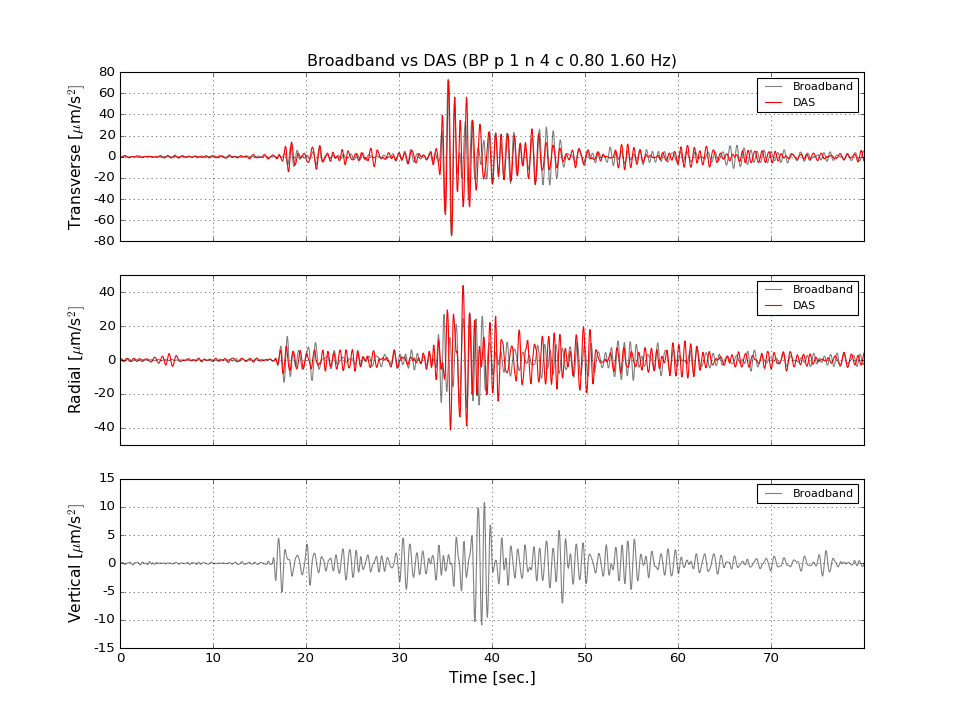

In [61]:
cstart=70
onestart=10
nchan=20

for freq_index in range(6):
    fmilist=[0.1,0.2,0.4,0.8,1.6,3.2]
    fmalist=[0.2,0.4,0.8,1.6,3.2,6.4]

    fmi=fmilist[freq_index]
    fma=fmalist[freq_index]
    nc=4

    c_stack = stack_stream_specific_median(c,cstart,nchan)
    one_stack = stack_stream_specific_median(one,onestart,nchan)

    c_acc_stack = v2a(c_stack)
    one_acc_stack = v2a(one_stack)

    bc_ese_acc = v2a(bb5a_IRR[0])
    bc_nne_acc = v2a(bb5a_IRR[1])
    bc_z_acc = v2a(bb5a_IRR[2])
    bn_ese_acc = v2a(bb59_IRR[0])
    bn_nne_acc = v2a(bb59_IRR[1])
    bn_z_acc = v2a(bb59_IRR[2])
    bs_ese_acc = v2a(baf7_IRR[0])
    bs_nne_acc = v2a(baf7_IRR[1])
    bs_z_acc = v2a(baf7_IRR[2])

    bc_ese_acc_bp = bpStream(bc_ese_acc,nc,fmi,fma)
    bc_nne_acc_bp = bpStream(bc_nne_acc,nc,fmi,fma)
    bc_z_acc_bp = bpStream(bc_z_acc,nc,fmi,fma)
    bn_ese_acc_bp = bpStream(bn_ese_acc,nc,fmi,fma)
    bn_nne_acc_bp = bpStream(bn_nne_acc,nc,fmi,fma)
    bn_z_acc_bp = bpStream(bn_z_acc,nc,fmi,fma)
    bs_ese_acc_bp = bpStream(bs_ese_acc,nc,fmi,fma)
    bs_nne_acc_bp = bpStream(bs_nne_acc,nc,fmi,fma)
    bs_z_acc_bp = bpStream(bs_z_acc,nc,fmi,fma)

    one_acc_bp = bpStream(one_acc_stack,nc,fmi,fma)
    c_acc_bp = bpStream(c_acc_stack,nc,fmi,fma)

    # Figure a
    fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
    ax[0].plot(bn_ese_acc_bp.data,'gray',label='Broadband')
    ax[1].plot(bn_nne_acc_bp.data,'gray',label='Broadband')
    ax[2].plot(bn_z_acc_bp.data,'gray',label='Broadband')

    ax[0].plot(-5.75*one_acc_bp.data,color='red',label='DAS')
    ax[1].plot(-5.75*c_acc_bp.data,color='red',label='DAS')

    ax[0].grid(which='both')
    ax[1].grid(which='both')
    ax[2].grid(which='both')
    ax[0].set_title('Broadband vs DAS (BP p 1 n %.0f c %0.2f %0.2f Hz)' % (float(nc),fmi,fma))
    ax[0].set_xlim([3400,5000])
    ax[0].set_ylabel('Transverse [$\mu$m/s$^{2}]$',fontsize=14)
    ax[1].set_ylabel('Radial [$\mu$m/s$^{2}]$',fontsize=14)
    ax[2].set_ylabel('Vertical [$\mu$m/s$^{2}]$',fontsize=14)
    ax[2].set_xticklabels(np.arange(0,80,10))
    ax[0].set_yticklabels([int(a/1000) for a in ax[0].get_yticks()])
    ax[1].set_yticklabels([int(a/1000) for a in ax[1].get_yticks()])
    ax[2].set_yticklabels([int(a/1000) for a in ax[2].get_yticks()])

    ax[2].set_xlabel('Time [sec.]',fontsize=14)
    ax[0].legend(loc='best',fontsize=10)
    ax[1].legend(loc='best',fontsize=10)
    ax[2].legend(loc='best',fontsize=10)
    plt.savefig('acceleration_comparison_%.1f_%.1fHz_median.eps' % (fmi,fma))